In [1]:
# !apt update
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
# !tar -xvf spark-3.3.0-bin-hadoop3.tgz
# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
import findspark
findspark.init()

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#%cd '/content/gdrive/My Drive/LDS9/Practice/Chapter9/'

/content/gdrive/My Drive/LDS9/Practice/Chapter9


# Demo KMeans Clustering

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('kmeans_demo').getOrCreate()

In [5]:
# Loads data.
data = spark.read.csv("5000_points.txt", header=False,
                      inferSchema=True, sep="\t")

In [6]:
data.show(3)

+------+------+
|   _c0|   _c1|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



In [34]:
import pyspark.sql.functions as f
from pyspark.ml.linalg import Vectors
import pyspark.ml.feature as feat
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd

In [9]:
data = data.select(f.col("_c0").alias("x"), f.col("_c1").alias("y"))

In [10]:
data.show(3)

+------+------+
|     x|     y|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



In [90]:
final_data = feat.VectorAssembler(inputCols=data.columns,
                                  outputCol='features').transform(data)

In [91]:
final_data.show(1)

+------+------+-------------------+
|     x|     y|           features|
+------+------+-------------------+
|664159|550946|[664159.0,550946.0]|
+------+------+-------------------+
only showing top 1 row



In [92]:
scaler_model = feat.StandardScaler(inputCol='features', 
                    withStd=True, 
                    withMean=False, 
                    outputCol='scale').fit(final_data)

In [93]:
final_data = scaler_model.transform(final_data)

In [94]:
final_data.show(3,False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scale                                  |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



In [16]:
# trains a k-means model
k_list = []
silhouette_ls = list()
sil_str = ''

for k in range(2,11):
    kmeans_model = KMeans(featuresCol='scale',
                          k=k).fit(final_data)
    k_list.append(k)
    
    # silhoutte
    pred = kmeans_model.transform(final_data)
    
    # evaluate clustering by computting sil score
    eval_ = ClusteringEvaluator()
    sil = eval_.evaluate(pred)
    silhouette_ls.append(sil)
    
    print(f'With k = {k} - Silhouette = {sil}\n')
    


With k = 2 - Silhouette = 0.4808556198158036

With k = 3 - Silhouette = 0.554174536585784

With k = 4 - Silhouette = 0.614662491276157

With k = 5 - Silhouette = 0.6172494269388334

With k = 6 - Silhouette = 0.6567390509816632

With k = 7 - Silhouette = 0.6156233224840827

With k = 8 - Silhouette = 0.6547243220736432

With k = 9 - Silhouette = 0.6886650332686685

With k = 10 - Silhouette = 0.7539451853469071



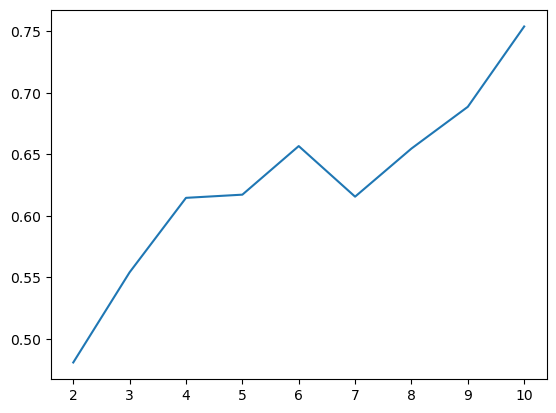

In [18]:
plt.plot(k_list,silhouette_ls)
plt.show()

In [117]:
kmeans_model = KMeans(featuresCol='scale',
                          k=9).fit(final_data)
    
# silhoutte
pred = kmeans_model.transform(final_data)

In [21]:
evaluator = ClusteringEvaluator().evaluate(pred)
print(f'Silhoutte = {evaluator}')

Silhoutte = 0.6886650332686685


In [22]:
centers = kmeans_model.clusterCenters()
centers

[array([2.23426443, 1.93910163]),
 array([1.00077305, 3.59412727]),
 array([3.3551708 , 3.09141176]),
 array([2.74371987, 3.65594142]),
 array([3.3833207 , 1.00022068]),
 array([1.69737985, 0.72534396]),
 array([1.70658457, 3.29747591]),
 array([3.49707086, 2.30655205]),
 array([0.88721777, 2.04459551])]

In [24]:
pred.show(5)

+------+------+-------------------+--------------------+----------+
|     x|     y|           features|               scale|prediction|
+------+------+-------------------+--------------------+----------+
|664159|550946|[664159.0,550946.0]|[2.71677561070036...|         0|
|665845|557965|[665845.0,557965.0]|[2.72367227803400...|         0|
|597173|575538|[597173.0,575538.0]|[2.44276602706395...|         0|
|618600|551446|[618600.0,551446.0]|[2.53041424234143...|         0|
|635690|608046|[635690.0,608046.0]|[2.60032174218239...|         0|
+------+------+-------------------+--------------------+----------+
only showing top 5 rows



In [25]:
pred.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  341|
|         6|  331|
|         3|  353|
|         5|  701|
|         4|  635|
|         8| 1042|
|         7|  365|
|         2|  326|
|         0|  906|
+----------+-----+



In [95]:
final_data.show(2)

+------+------+-------------------+--------------------+
|     x|     y|           features|               scale|
+------+------+-------------------+--------------------+
|664159|550946|[664159.0,550946.0]|[2.71677561070036...|
|665845|557965|[665845.0,557965.0]|[2.72367227803400...|
+------+------+-------------------+--------------------+
only showing top 2 rows



In [96]:
temp = final_data.select('scale').toPandas()

In [97]:
temp['x1'] =  temp.scale.apply(lambda x: x[0])

In [98]:
temp['x2'] = temp.scale.apply(lambda x: x[1])

In [99]:
split_data = spark.createDataFrame(data=temp[['x1','x2']])

In [100]:
split_data.count()

5000

In [101]:
split_data=split_data.withColumn('row_index', f.monotonically_increasing_id())
final_data=final_data.withColumn('row_index', f.monotonically_increasing_id())

In [102]:
final_data.show(5)

+------+------+-------------------+--------------------+---------+
|     x|     y|           features|               scale|row_index|
+------+------+-------------------+--------------------+---------+
|664159|550946|[664159.0,550946.0]|[2.71677561070036...|        0|
|665845|557965|[665845.0,557965.0]|[2.72367227803400...|        1|
|597173|575538|[597173.0,575538.0]|[2.44276602706395...|        2|
|618600|551446|[618600.0,551446.0]|[2.53041424234143...|        3|
|635690|608046|[635690.0,608046.0]|[2.60032174218239...|        4|
+------+------+-------------------+--------------------+---------+
only showing top 5 rows



In [108]:
final_data[['row_index']].distinct().count()

5000

In [110]:
temp = final_data.join(split_data, on=["row_index"],how='leftouter')

In [111]:
temp.show(5)

+---------+------+------+-------------------+--------------------+------------------+------------------+
|row_index|     x|     y|           features|               scale|                x1|                x2|
+---------+------+------+-------------------+--------------------+------------------+------------------+
|        0|664159|550946|[664159.0,550946.0]|[2.71677561070036...| 2.716775610700365| 2.336092297255214|
|        1|665845|557965|[665845.0,557965.0]|[2.72367227803400...|2.7236722780340017|2.3658538924649704|
|        2|597173|575538|[597173.0,575538.0]|[2.44276602706395...|2.4427660270639544| 2.440366004250274|
|        3|618600|551446|[618600.0,551446.0]|[2.53041424234143...|2.5304142423414357|2.3382123709986073|
|        4|635690|608046|[635690.0,608046.0]|[2.60032174218239...|2.6003217421823916|2.5782047187507375|
+---------+------+------+-------------------+--------------------+------------------+------------------+
only showing top 5 rows



In [112]:
temp = temp.select(f.col("x1").alias("x_scale"), f.col("x2").alias("y_scale"))

In [113]:
temp.count()

5000

In [114]:
pred=pred.withColumn('row_index', f.monotonically_increasing_id())
temp=temp.withColumn('row_index', f.monotonically_increasing_id())
#pred = pred.join(temp, on=["row_index"]).sort("row_index")

In [119]:
pred.show(5)

+------+------+-------------------+--------------------+---------+----------+
|     x|     y|           features|               scale|row_index|prediction|
+------+------+-------------------+--------------------+---------+----------+
|664159|550946|[664159.0,550946.0]|[2.71677561070036...|        0|         0|
|665845|557965|[665845.0,557965.0]|[2.72367227803400...|        1|         0|
|597173|575538|[597173.0,575538.0]|[2.44276602706395...|        2|         0|
|618600|551446|[618600.0,551446.0]|[2.53041424234143...|        3|         0|
|635690|608046|[635690.0,608046.0]|[2.60032174218239...|        4|         0|
+------+------+-------------------+--------------------+---------+----------+
only showing top 5 rows



In [120]:
temp.show(5)

+------------------+------------------+---------+
|           x_scale|           y_scale|row_index|
+------------------+------------------+---------+
|2.3017688584262777|2.4194111953705737|        0|
|2.3268030245483753|2.4177448174082663|        1|
|              null|              null|        2|
|              null|              null|        3|
|              null|              null|        4|
+------------------+------------------+---------+
only showing top 5 rows



In [116]:
pred.show()

+---------+------+------+-------------------+--------------------+----------+-----------------+-----------------+------------------+------------------+
|row_index|     x|     y|           features|               scale|prediction|          x_scale|          y_scale|           x_scale|           y_scale|
+---------+------+------+-------------------+--------------------+----------+-----------------+-----------------+------------------+------------------+
|        0|664159|550946|[664159.0,550946.0]|[2.71677561070036...|         0|2.716775610700365|2.336092297255214|2.3017688584262777|2.4194111953705737|
|        1|665845|557965|[665845.0,557965.0]|[2.72367227803400...|         0|2.716775610700365|2.336092297255214|2.3268030245483753|2.4177448174082663|
|        2|597173|575538|[597173.0,575538.0]|[2.44276602706395...|         0|2.716775610700365|2.336092297255214|              null|              null|
|        3|618600|551446|[618600.0,551446.0]|[2.53041424234143...|         0|2.716775610

In [115]:
visual = pred[['x_scale','y_scale','prediction']].toPandas()

AnalysisException: Reference 'x_scale' is ambiguous, could be: x_scale, x_scale.